# Индивиуальное задание

## Этап  № 6. Построение общей модели на основе случайных полей и статической модели блокировки

_Выполнил_ студент 2 курса<br>
учебной группы НММ-02-22<br>
Мулин Иван

### Цели
Построить согласно описанному ниже алгоритму имитационную модель, позволяющую вычислить среднее значение интерференции; построить графики зависимости среднего значения интерференции от угла диаграммы направленности, интенсивности Пуассоновского поля источников интерферирующих устройств B, интенсивности Пуассоновского поля блокирующих объектов A.

### Задача

В круге радиуса R, центром которого является целевой приемник, распределены согласно Пуассоновскому равномерному точечному процессу с интенсивностью B интерферирующие устройства. На целевом приемнике расположена всенаправленная антенна, а интерферирующие устройства оборудованы направленными антеннами с углом диаграммы направленности γ. Предполагается, что все антенны сориентированы случайным образом и постоянно излучают сигнал с мощностью P. При этом применяется модель распространения сигнала Cone (аналог модели Free Space Path Loss с поправкой на коэффициент диаграммы направленности). В этом же круге согласно Пуассоновскому равномерному точечному процессу с интенсивностью A распределены блокирующие объекты радиуса D. Для упрощения интерферирующие устройства не считать блокирующими объектами.

В случае если сигнал от интерферирующего передатчика до целевого приемника проходит через блокирующий объект, то он не создает помех на целевом приемнике. Аналогично, если целевой приемник не попадает в сектор диаграммы направленности интерферирующего передатчика, то соответствующий интерферирующий сигнал тоже не создает помех.

На основе полученной модели построить графики среднего значения интерференции как функции от направленности антенн γ, интенсивности Пуассоновского поля источников интерферирующих устройств B, интенсивности Пуассоновского поля блокирующих объектов A. При построении графиков использовать как минимум 1000 реализаций.

### Ход работы

Подключаем нужные и ненужные библиотеки. После этого вводим константы, данные по условию.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.linalg import norm
from numpy import cross, dot, arcsin, arccos, pi

In [2]:
FieldRadius = 6
bRadius = 0.5
power = 1
BlckParameter, IntfrParameter = 10, 6
N = 1000

angles = np.linspace(0, 2 * pi, 80)

Опишем функции, необходимые для построения модели.

In [3]:
# Functions for drawing

def DrawCircle(x0, y0, r, outerhue="#89cfd9", fillhue="#a6c1e0", ls="solid"):
    """
    Draws a circle on a plot.
    """
    global angles
    xs = x0 + r*np.cos(angles)
    ys = y0 + r*np.sin(angles)
    plt.plot(x0, y0, color=outerhue, marker=".")
    plt.plot(xs, ys, color=outerhue, linestyle=ls)
    plt.fill(xs, ys, color=fillhue)

def DrawAngle(x0, y0, angle, mu, hue1="#39dba0"):
    """
    Draws angle of vision at (x0, y0) rotated by mu radians.
    """
    x1, y1 = x0 + np.cos(mu), y0 + np.sin(mu)
    x2, y2 = x0 + np.cos(mu - angle), y0 + np.sin(mu - angle)
    plt.plot((x0, x1), (y0, y1), color=hue1)
    plt.plot((x0, x2), (y0, y2), color=hue1)

In [4]:
# Algebraic functions

def sign(x):
    """
    A mathematical sgn(x).
    """
    if x == 0:
        return 0
    return x/abs(x)

def Distance(x1, y1, x2, y2):
    """
    A normal euclidean plane metric.
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def CalDistance(L, P):
    """
    Calculates distance between line Ax+By+C=0 and point P=(x0 y0).
    (L=(A B C).)
    """
    Q = L[:-1]
    R = np.append( np.transpose(P), 1)
    return abs( np.matmul(L, R) ) / norm(Q)

def GetLine(x1, y1, x2, y2):
    """
    Calculates vector (A B C) for a line Ax+By+C=0.
    """
    det = x1*y2 - x2*y1
    if det != 0: # y=kx+s, s!=0
        A = (y1-y2) / det
        B = (x2-x1) / det
        return np.array([A, B, 1])
    
    if x1**2 + y1**2 == 0 or x1==0 or y1==0: # if x1=y1, that is not a line!
        return np.array([0, 1, 0])
        
    # ...then it is y=kx, k!=0
    B = -1
    A = y1/x1
    return np.array([A, B, 0])

def PointInSection(b, c):
    """
    Determines whether point is in section. Angles b, c to be passed.
    """
    return (0 <= b) * (b <= c)

In [5]:
def PoissonProcessInitializer(lam, R, angle=2*pi, precision=0.0000001, x0=0, y0=0):
    """
    Initializes Poisson process.
    """
    amount = np.random.poisson(lam)
    r = np.random.uniform(0, R, size=amount)
    o = np.random.uniform(0, angle, size=amount)
    
    x, y = x0 + r * np.cos(o), y0 + r * np.sin(o)
    x -= x % precision
    y -= y % precision
    return list(zip(x, y))

In [6]:
class Diagram:
    """
    Diagram is two sectors of vision.
    """
    def __init__(self,\
                 x, x0, y, y0, power,\
                 mu, angle\
                ):
        # Line of sight stuff
        self.x, self.y = x, y
        self.power = power
        self.distance = norm([x0-x, y0-y])
        if self.distance == 0:
            self.incline = 0
        else:
            self.incline = sign( arcsin((y0-y)/self.distance) ) * arccos((x0-x)/self.distance)

        # Sectors of vision stuff
        self.VSangle, self.mu = angle, mu

    
    def DrawVisionSector(self, ihue="#9748d9", vhue="#d9b948"):
        """
        Draws vision sector.
        """
        DrawAngle(self.x, self.y, self.VSangle, self.mu+self.incline, vhue)
        plt.plot(self.x, self.y, marker='x', color=ihue)

In [7]:
def BornInterferences(VSangle, lam, R, maxangle=2*pi, precision=0.0000001, x0=0, y0=0):
    global power
    positions = PoissonProcessInitializer(lam, R, maxangle, precision, x0, y0)
    l = len(positions)
    interferences = np.empty(l, dtype=Diagram)
    angles = np.random.uniform(0, maxangle, size=l)
    for i in range(l):
        interferences[i] = Diagram(positions[i][0], x0, positions[i][1], y0, power, angles[i], VSangle)
    return interferences

In [8]:
def IsBlocked(I, B):
    """
    Checks if interference I's signal is blocked.
    """
    global bRadius
    y = I.VSangle
    dist = Distance(I.x, I.y, *B)
    if bRadius >= dist:
        return 1
    M = I.mu+I.incline
    ray = np.cos(M), np.sin(M)
    connector = [B[0]-I.x, B[1]-I.y]
    product = dot(ray, connector)/dist
    
    os = arcsin(bRadius/dist)
    o = sign(cross(ray, connector)) * arccos(product)

    #plt.plot((I.x, I.x+ray[0]), (I.y, I.y+ray[1]), linestyle="dashed", color="#b88ed4")
    #plt.plot((I.x, I.x+connector[0]), (I.y, I.y+connector[1]), linestyle="dashed", color="#8ed496")

    return ( abs(o) <= y+os ) * (dist <= I.distance + bRadius)

In [9]:
def TotalInterference(blockators, interferences: list[Diagram], x0=0, y0=0):
    """
    Will check interference.
    """
    if len(interferences) == 0:
        return 0
    P = interferences[0].power
    y = interferences[0].VSangle
    I = 0
    for i in interferences:
        if not PointInSection(i.mu, i.VSangle):
            continue
        for b in blockators:
            if IsBlocked(i, b):
                continue
        # signal interferes
        I += i.distance ** (-2)

    G = np.sin(y/4) ** (-2)
    I *= (P * G) / (4 * pi)
    return I

In [10]:
def MeanInterference(N, VisionAngle, BlockParameter, InterferenceParameter):
    global FieldRadius
    I = 0
    for n in range(N):
        blockators = PoissonProcessInitializer(BlockParameter, FieldRadius)
        interferences = BornInterferences(VisionAngle, InterferenceParameter, FieldRadius)
        I += TotalInterference(blockators, interferences)
    return I / N

### Тестовая модель
Участок кода ниже предназначен для проверки работы написанных функций.

0.0


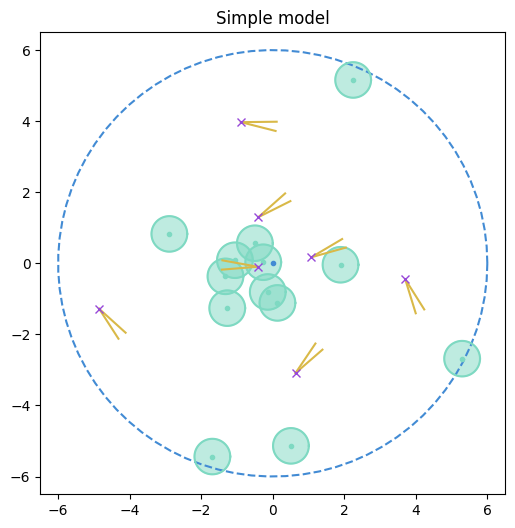

In [11]:
VisionAngle = np.random.uniform(0.001, pi/3)

blockators = PoissonProcessInitializer(BlckParameter, FieldRadius)
interferences = BornInterferences(VisionAngle, IntfrParameter, FieldRadius)
plt.figure(dpi=100, figsize=(6, 6))
plt.title("Simple model")

DrawCircle(0, 0, FieldRadius, "#428bd4", "#ffffff", "dashed")
for b in blockators:
    DrawCircle(b[0], b[1], bRadius, "#7ed9c2", "#7ed9c2"+"80")
for i in interferences:
    i.DrawVisionSector()

print( TotalInterference(blockators, interferences) )

u = FieldRadius + bRadius
plt.xlim(-u, u)
plt.ylim(-u, u)
plt.show()

0.0


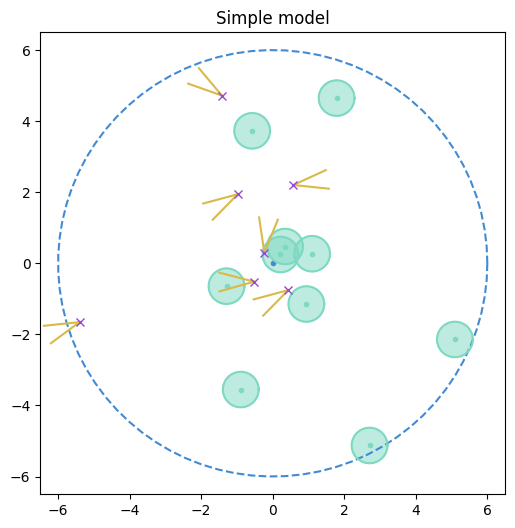

In [12]:
VisionAngle = np.random.uniform(0.001, pi/3)

blockators = PoissonProcessInitializer(BlckParameter, FieldRadius)
interferences = BornInterferences(VisionAngle, IntfrParameter, FieldRadius)
plt.figure(dpi=100, figsize=(6, 6))
plt.title("Simple model")

DrawCircle(0, 0, FieldRadius, "#428bd4", "#ffffff", "dashed")
for b in blockators:
    DrawCircle(b[0], b[1], bRadius, "#7ed9c2", "#7ed9c2"+"80")
for i in interferences:
    i.DrawVisionSector()

print( TotalInterference(blockators, interferences) )

u = FieldRadius + bRadius
plt.xlim(-u, u)
plt.ylim(-u, u)
plt.show()

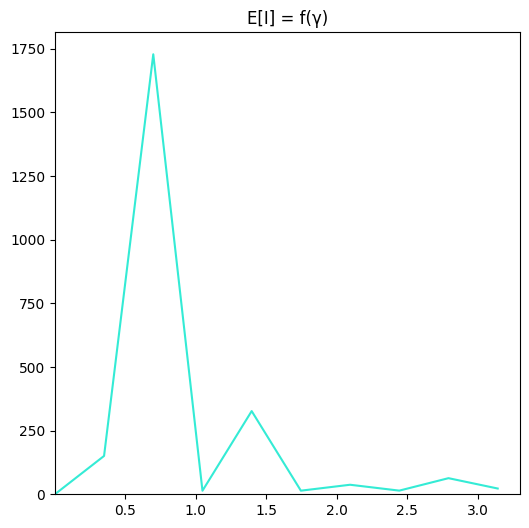

In [13]:
Y = np.linspace(0.001, pi, 10)
EIs = np.empty(len(Y))
for y in range( len(Y) ):
    EIs[y] = MeanInterference(N, Y[y], BlckParameter, IntfrParameter)

plt.figure(dpi=100, figsize=(6, 6))
plt.title("E[I] = f(γ)")

plt.plot(Y, EIs, color="#34ebd5")

plt.xlim(min(Y)*0.95, max(Y)*1.05)
plt.ylim(0, max(EIs)*1.05)
plt.show()

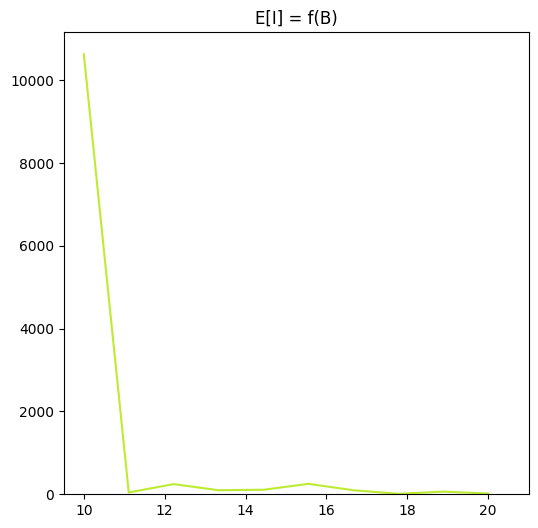

In [14]:
BlckParameters = np.linspace(10, 20, 10)
EIs = np.empty(len(BlckParameters))
for b in range( len(BlckParameters) ):
    EIs[b] = MeanInterference(N, VisionAngle, BlckParameters[b], IntfrParameter)

#EIs = savgol_filter(EIs, len(EIs), 3) # smooth the graph if you wish

plt.figure(dpi=100, figsize=(6, 6))
plt.title("E[I] = f(B)")

plt.plot(BlckParameters, EIs, color="#bdeb34")

plt.xlim(min(BlckParameters)*0.95, max(BlckParameters)*1.05)
plt.ylim(0, max(EIs)*1.05)
plt.show()

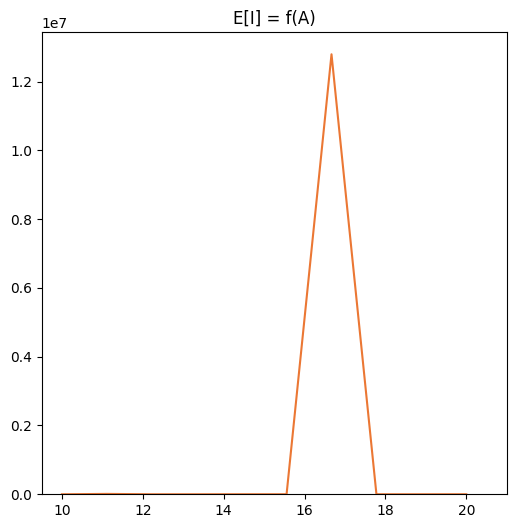

In [15]:
IntfrParameters = np.linspace(10, 20, 10)
EIs = np.empty(len(IntfrParameters))
for i in range( len(IntfrParameters) ):
    EIs[i] = MeanInterference(N, VisionAngle, BlckParameter, IntfrParameters[i])
# EIs = savgol_filter(EIs, len(EIs), 3) # smooth the graph if you wish

plt.figure(dpi=100, figsize=(6, 6))
plt.title("E[I] = f(A)")

plt.plot(IntfrParameters, EIs, color="#eb7734")

plt.xlim(min(IntfrParameters)*0.95, max(IntfrParameters)*1.05)
plt.ylim(0, max(EIs)*1.05)
plt.show()

### Вывод

В результате в выполнения данного этапа индивидуального проекта были разработаны инструменты, позволяющие рассчитать среднее значение интерференции сигнала в зоне действия радиовышки.